O. Pannekoucke$^{1,2,3}$

$^1$ INPT-ENM, Toulouse, France

$^2$ CNRM, Université de Toulouse, Météo-France, CNRS, Toulouse, France

$^3$ CERFACS, Toulouse, France

(olivier.pannekoucke@meteo.fr)

**Abstract**

This notebook illustrates the use of sympkf to build and handle the PKF dynamics associated with the Burgers' equation given by the non-linear advection plus a diffusion
$$\partial_t u + u\partial_x u = \kappa \partial_x^2 u.$$
For this dynamics, the resulting PKF system is not closed, and we show how to introduce a closure at a symbolic level. The notebook ends with a numerical simulation, which illustrates how a numerical code can be automaticaly generated by using SympPKF, then used to perform a numerical simulation.

# Definition of the Burgers' dynamics

In [1]:
# Import of libraries
import sympy
from sympy import init_printing, symbols, Function, Derivative, Eq, Integer, Rational
init_printing() 

from sympkf import Expectation, PDESystem, SymbolicPKF, FDModelBuilder, t

**Definition of the dynamics from sympy tools**

In [2]:
# Set the spatial coordinate system
x = symbols('x')
# Set the constants
kappa = symbols('kappa')
# Define the spatio-temporal scalar field
u = Function('u')(t,x)

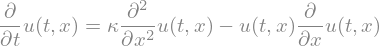

In [3]:
# Definition of the Burgers dynamics
burgers_equation = Eq(Derivative(u,t), 
    -u*Derivative(u,x)+kappa*Derivative(u,x,2))
burgers_equation

In [4]:
# Processing of the PDE system
burgers = PDESystem( burgers_equation )
burgers

PDE System :
        prognostic functions : u(t, x)
        constant functions   : 
        exogeneous functions : 
        constants            : kappa
        

# Computation of the PKF dynamics by using SymPKF

## Direct computation of the PKF dynamics

In [5]:
pkf_burgers = SymbolicPKF(burgers)

Computation of the PKF dynamics as given in metric and in aspect tensor form.

In [6]:
import time
start = time.time()
pkf_burgers.in_metric
pkf_burgers.in_aspect
end = time.time()
print(end - start)

1.4094231128692627


In [7]:
pkf_burgers = SymbolicPKF(burgers)

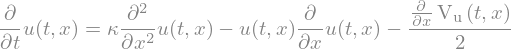

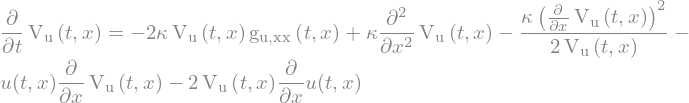

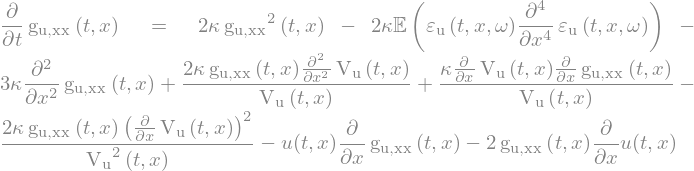

In [8]:
for equation in pkf_burgers.in_metric: display(equation)

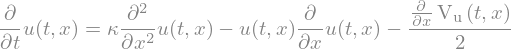

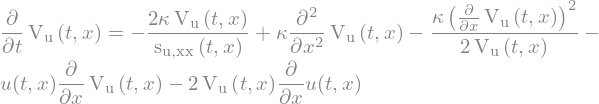

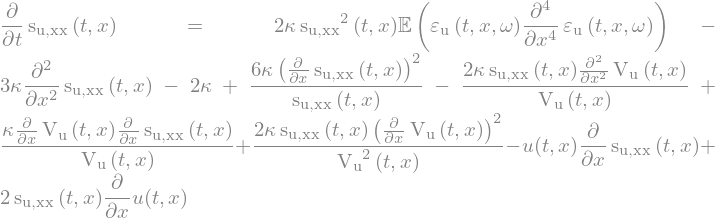

In [9]:
for equation in pkf_burgers.in_aspect: display(equation)

It follows that the PKF dynamics is unclosed since the term $\mathbb{E}[\varepsilon\partial_x^4\varepsilon]$ is not given as a function of the prognostic variables $u$,$V_u$ and $g_{u,xx}$ (or $s_{u,xx}$ when the dynamics is given in aspect tensor form).

## Sequential computation of the PKF dynamics using the splitting strategy

The computation of the dynamics can be considered in two steps thanks to the splitting dynamics described in Pannekoucke and Arbogast (2021).

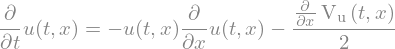

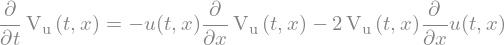

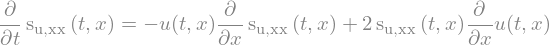

In [10]:
# PKF for the non-linear advection
nladvection_pkf = SymbolicPKF(
    Eq(Derivative(u,t), -u*Derivative(u,x))
)

for equation in nladvection_pkf.in_aspect: display(equation)

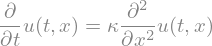

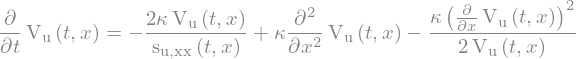

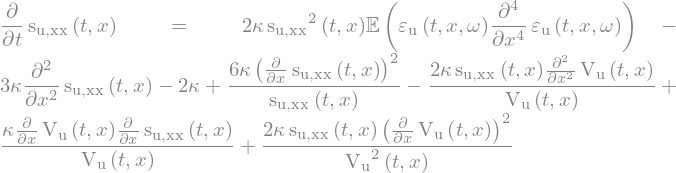

In [11]:
# PKF for the diffusion
diffusion_pkf = SymbolicPKF(
    Eq(Derivative(u,t), kappa*Derivative(u,x,2))
)

for equation in diffusion_pkf.in_aspect: display(equation)

Merging the resulting above dynamics provide the PKF dynamics of the full Burgers' equation.

## Exploration of the substitution tree

Note that the computation of the PKF dynamics relies on the transformation of terms in $\mathbb{E}[\partial^\alpha\varepsilon\partial^\beta\varepsilon]$ into terms in $\mathbb{E}[\varepsilon\partial^\gamma\varepsilon]$ where $\gamma\leq\alpha+\beta$.

This transformation is handled in SymPKF thanks to a substitution dictionnary, which can be displayed as follows

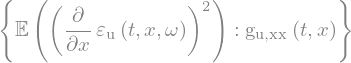

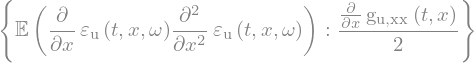

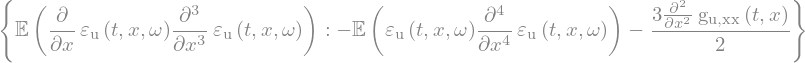

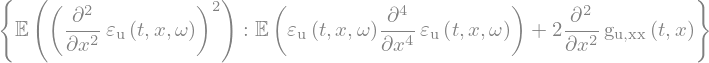

In [12]:
for key, value in pkf_burgers.subs_tree.items():
    display({key:value})

## Itermediate conclusion

Since the PKF equation are not closed. We now introduce an illustration of a closure resulting from the work of [Pannekoucke et al. (2018)](https://doi.org/10.5194/npg-2018-10)

# Introduction of a closure for the PKF dynamics applied for the Burgers' equation

First, the unclosed terms can be obtained from the instance of the class `SymbolicPKF`.

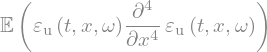

In [13]:
for term in pkf_burgers.unclosed_terms:
    display(term)

In [14]:
unclosed_term = list(pkf_burgers.unclosed_terms)[0]

## Data-driven exploration of closure

[Pannekoucke and Fablet (2020)](https://doi.org/10.5194/gmd-13-3373-2020) has proposed a data-driven approach for closing a PKF dynamics. This relies on the proposal of closure. An approach for such proposals can rely of approximation of correlations.

For instance, if a correlation function is approximated by a "quasi"-gaussian function
$$\rho(x,x+\delta x) \approx \exp\left({-\frac{\delta x^2}{s(x)+s(x+\delta x)}}\right),$$
then the identification in the Taylor expansion of the correlation 
\begin{equation}
\rho(x,x+\delta x) = \sum_k \frac{1}{k!}\mathbb{E}\left(\varepsilon(x)\partial_x^k \varepsilon( x)\right)\delta x^k,
\end{equation}
can leads to proposal closure for terms $\mathbb{E}\left(\varepsilon \partial_x^k \varepsilon\right)$.

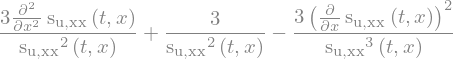

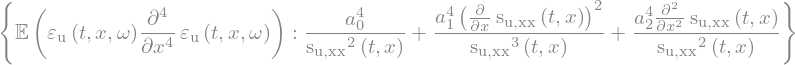

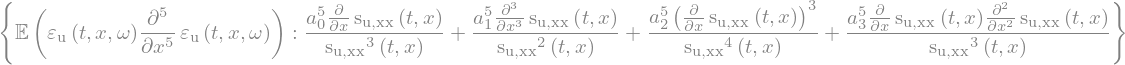

In [15]:
from sympkf import remove_eval_derivative

s = pkf_burgers.fields[u].aspect[0]
eps = pkf_burgers.fields[u].epsilon
dx = sympy.Symbol('\delta x')

# definition of the correlation
rho = sympy.exp(- dx*dx / ( s + s.subs(x,x+dx) ) )

# Taylor expansion of the correlation with respect to dx, at order 6
taylor_order = 6
taylor = rho.series(dx,0,taylor_order)
taylor = remove_eval_derivative(taylor.removeO())

# Definition of pattern for the design of closure proposals
a = sympy.Wild("a",properties=[lambda k: k.is_Rational])
b = sympy.Wild("b")

for order in [4,5]:
    # Extract the term of a given order
    expr = taylor.coeff(dx,order)*sympy.factorial(order)    
    if order==4: display(expr)
    # Create a proposal for the term at the order from pattern matching
    expr = sum([sympy.symbols(f'a_{k}^{order}')*term.match(a*b)[b] 
                for k,term in enumerate(expr.args)] )
    display({Expectation(eps*Derivative(eps,x,order)):expr})

In the above results, the terms $\mathbf{a}=(a_0^4,a_1^4,a_2^4)$ denotes unknown scalar 
that remains to estimate from a machine learning approach, e.g. the method proposed by [Pannekoucke and Fablet (2020)](https://doi.org/10.5194/gmd-13-3373-2020) which relies on an automatic generation of neural-network architecture.

While interesting, this kind of approach is not detailed here, and we now introduce a known closure for the PKF applied to the Burgers' equation, namely the closure proposed by [Pannekoucke et al. (2018)](https://doi.org/10.5194/npg-2018-10).

## Introduction of a the closure proposed by Pannekoucket et al. (2018)

The closure proposed in [Pannekoucke et al. (2018)](https://doi.org/10.5194/npg-2018-10) reads as 
$$\mathbb{E}[\varepsilon\partial_x^4\varepsilon]\sim 3g_{u,xx}^2 -2\partial_x^2 g_{u,xx},$$
where $\sim$ means that this is not an equality (since we do not know the term), but a proposal of closure.
This closure can be introduced as follows.

### Definition of the closure

In [16]:
from sympy import Integer
g = pkf_burgers.fields[u].metric[0] # metric tensor
s = pkf_burgers.fields[u].aspect[0] # aspect tensorc

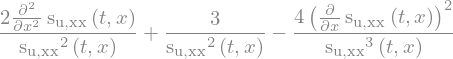

In [17]:
P18_closure = Integer(3)*g**Integer(2)-Integer(2)*Derivative(g,x,2)
P18_closure = P18_closure.subs(g,1/s).doit().expand()
display(P18_closure)

### Introduction of the closure in the PKF dynamics

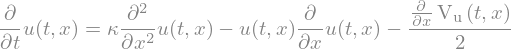

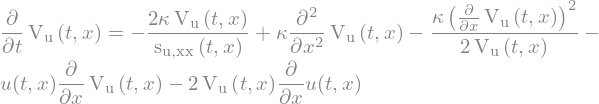

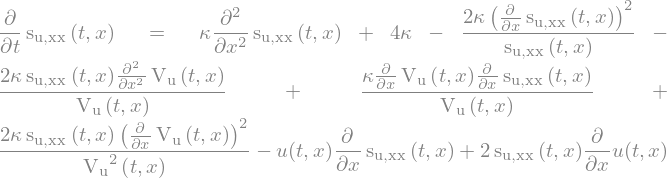

In [18]:
for equation in pkf_burgers.in_aspect:
    display(equation.subs(unclosed_term,P18_closure).expand())

## Itermediate conclusion

Now, the PKF dynamics being closed, it is possible to perform numerical simulation so to assess the ability of the PKF dynamics to reproduce the covariance dynamics in the Burgers' equation

# Numerical experiment to assess the skill of the closed PKF dynamics

In the numerical example, we consider the dynamics written in aspect tensor form.

## Automatic code generation from the closed PKF system

SymPKF comes with a python numerical code generator which translate a system of partial differential equation into a python's code using `numpy` and where the partial derivative with respect to spatial coordinates are approximated thanks to a finite difference approach, consistent at the second order.

In what follows, we illustrate another way to introduce a closure. 

In [19]:
from sympy import Integer
from sympkf import FDModelBuilder

g = pkf_burgers.fields[u].metric[0] # metric tensor
s = pkf_burgers.fields[u].aspect[0] # aspect tensor

# loc. Gaussian closure of P18 in metric form, then in aspect form
P18_closure = Integer(3)*g**Integer(2)-Integer(2)*Derivative(g,x,2)
P18_closure = P18_closure.subs(g,1/s).doit().expand()

# Introduction of the closure as a dictionnary
unclosed_term = list(pkf_burgers.unclosed_terms)[0]
pkf_burgers.set_closure({unclosed_term:P18_closure})

# Build a numerical code at runtime
exec(FDModelBuilder(pkf_burgers.in_aspect, class_name='ClosedPKFBurgers').code)
closed_pkf_burgers = ClosedPKFBurgers(shape=(241,))

**Sample of the numerical code generated in the class `ClosedPKFBurgers`**

```python
[..]
# Compute derivatives
#-----------------------
DV_u_x_o1 = (-V_u[np.ix_(self.index('x',-1))] + V_u[np.ix_(self.index('x',1))])/(2*self.dx[self.coordinates.index('x')])

[..]
# Implementation of the trend
#--------------------------------
du[:] = -DV_u_x_o1/2 - Du_x_o1*u + Du_x_o2*kappa

dV_u[:] = -DV_u_x_o1**2*kappa/(2*V_u) - DV_u_x_o1*u + DV_u_x_o2*kappa - 2*Du_x_o1*V_u - 2*V_u*kappa/s_u_xx

ds_u_xx[:] = 2*DV_u_x_o1**2*s_u_xx*kappa/V_u**2 + DV_u_x_o1*Ds_u_xx_x_o1*kappa/V_u - 2*DV_u_x_o2*s_u_xx*kappa/V_u - 2*Ds_u_xx_x_o1**2*kappa/s_u_xx - Ds_u_xx_x_o1*u + Ds_u_xx_x_o2*kappa + 2*Du_x_o1*s_u_xx + 4*kappa
[..]
```

In the last lines,
```python
exec(FDModelBuilder(pkf_burgers.in_aspect, class_name='ClosedPKFBurgers').code)
closed_pkf_burgers = ClosedPKFBurgers(shape=(241,))
```
first a class `ClosedPKFBurgers` is created at runtime, then an instance of this class, that is `closed_pkf_burgers`.
The discretization is made with $241$ grid points, while the length of the domain is $1$.

In [20]:
# Uncomment the following line if you want to see the code generated by sympkf
#print(FDModelBuilder(closed_pkf, class_name='ClosedPKFBurgers').code)

## Numerical experiment

In [21]:
import matplotlib.pyplot as plt

In [22]:
def plot_results(data, label=None, labelx=True, title=None, save_file=None, normalisation=None, 
                 selected_times=None,style=None, name=None, alpha=1., bolds=[0., 1.]):
    
    normalisation = 1. if normalisation is None else normalisation
                 
    selected_times = [time for time in data] if selected_times is None else selected_times
                 
    style = 'k' if style is None else style
                 
    for time in selected_times:
        lalpha = alpha if time in bolds else 0.2
        lname = name if time==selected_times[-1] else None
        plt.plot(domain.x[0],data[time]/normalisation, style, alpha = lalpha, label=lname)
                 
    if labelx:
        plt.xlabel('$x/D$', fontsize=15)
    if label:
        plt.ylabel(label, fontsize=15)
    if title:
        plt.title(title)
    if save_file:
        plt.savefig(save_file)

**Definition of the physical domain of computation**

In [23]:
domain = closed_pkf_burgers

In [24]:
domain.shape, domain.lengths

**Set initial fields**

In [25]:
import numpy as np

In [26]:
# Set initial condition for U (ensemble averaged velocity field)
Umax = 0.5  
U0=Umax*( 1+np.cos(2*np.pi/ domain.lengths[0]  *(domain.x[0]-0.25)) ) *0.5

# Set initial condition for V (variance)
V0 = (0.01*Umax)**2 + np.zeros(domain.shape[0])

# Set initial condition for s (aspect tensor)
lh = 0.02*domain.lengths[0]
s0 = lh**2 + + np.zeros(domain.shape[0])

# build the initial state vector as used for the prediction in the numerical code
state0 = np.asarray([U0, V0, s0])
normalization = {
                '(a) Velocity':U0.max(), 
                '(b) Variance':V0.max(), 
                '(c) Length-scale':lh
                }

**Set the parameters of simulation**

In [27]:
# Set the diffusion coefficient $\kappa$.

dt_front = 0.005
kappa = Umax*dt_front

closed_pkf_burgers.kappa = kappa

In [28]:
kappa

In [29]:
dt = 0.002               # default time step
refine_time = int(1)    # used to increase the time resolution (reduce the time step)
time_simulation = 1.
closed_pkf_burgers.set_dt(dt/refine_time)
times = closed_pkf_burgers.window(time_simulation)
saved_times = times[::50*refine_time]          

In [30]:
closed_pkf_burgers._dt

**Computation of a short forecast**

In [31]:
pkf_trajectory = closed_pkf_burgers.forecast(times, state0, saved_times)

**Plot results**

In [32]:
length_scale = lambda s: np.sqrt(s)

def plot_vlatcov_stat(trajectory, name, style='k', subplot=False):
    if not subplot: plt.figure(figsize=(14,4))
    for k,field,label in zip(range(3),normalization,"abc"):
        if field=='Length-scale':
            data = {time:length_scale(trajectory[time][k]) for time in trajectory}
        else:
                data = {time:trajectory[time][k] for time in trajectory}
        plt.subplot(131+k)
        plot_results(data,style=style,label=field, name=name,normalisation=normalization[field])
        #plt.title(f'({label})')
        if k==0: 
            plt.legend()

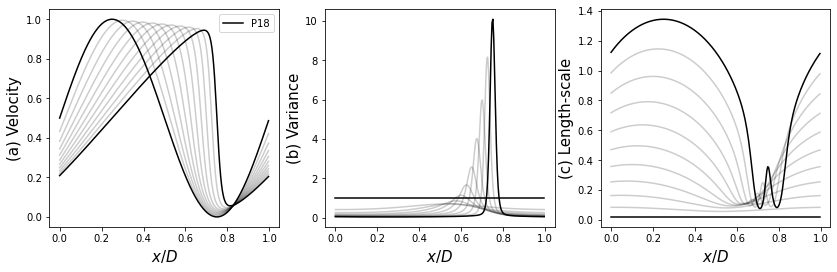

In [33]:
plot_vlatcov_stat(pkf_trajectory, name='P18')

## Ensemble validation of the PKF dynamics

### Generation and diagnosis of an initial ensemble of forecast error

**Generation of an ensemble of initial error**

We consider that the initial covariance matrix $\mathbf{P}^f_0$ is so that the correlation functions are the Gaussian
functions
$$\rho_h(x,y) = e^{-\frac{(x-y)^2}{2l_h^2}},$$
where $l_h$ denotes the correlation length-scale.

Hence, any Gaussian sample $\varepsilon^f\sim\mathcal{N}(0,\mathbf{P}^f_0)$ from this covariance matrix is defined from the transformation 
$$\varepsilon^f = {\mathbf{P}^f_0}^{1/2}\zeta,$$
where $\zeta\sim\mathcal{N}(0,\mathbf{I})$ is a sample of a nomalized Gaussian of zero mean and covariance matrix the identity matrix $\mathbf{I}$.

Since the correlation function is the same at each point of the domain (the correlation is homogeneous), the covariance matrix $\mathbf{P}^f_0$ is diagonal in Fourier's space (spectral space). In this illustration we build forecast-error sample from the Fourier's space.

In [34]:
# construction of the initial covariance matrix $P_0$
# 1) Definition of the correlation function on the circle
gauss = lambda dx : np.exp(-0.5*dx**2/lh**2) # lh has been previously specified 
correlation = gauss(domain.x[0]-domain.x[0][domain.shape[0]//2])

spectrum = np.abs(np.fft.fft(correlation))

# 2) Computation of the square root matrix
std_spectrum = np.sqrt(spectrum)

# 3) Routine to peform a Gaussian sample from the homogeneous correlation of the given sqrt-spectrum
def make_sample():
    zeta = np.random.normal(size=domain.shape)
    zeta = np.fft.fft(zeta)
    ef = np.fft.ifft(std_spectrum * zeta)
    ef = np.real(ef)
    return ef

# 4) Routine to perfrom an ensemble of error of given size
def make_init_ensemble(mean, variance, Ne):
    """ Generate an ensemble of forecast-error """
    return np.array([mean+np.sqrt(variance)*make_sample() for k in range(Ne)])

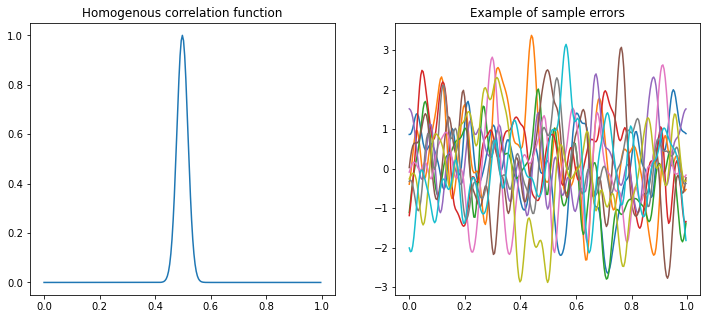

In [35]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(domain.x[0], correlation)
plt.title('Homogenous correlation function');
plt.subplot(122)
for k in range(10):
    plt.plot(domain.x[0], make_sample())
plt.title("Example of sample errors");

**Diagnosis of the covariance, variance, anisotropy from an ensemble**

In [36]:
def estimate_covariance(ensemble):
    """ Estimate the covariance function from an ensemble
    ensemble : array
    """
    mean = ensemble.mean(0)
    error = (ensemble - mean)/np.sqrt(len(ensemble))
    return error.T @ error

class EnsembleDiagnosis(object):
    """ Diagnosis tool of the variance and of the anisotropy for a covariance 
    model parameterized from this two features (VLATcov model)
    """
    def __init__(self, ensemble, base_space):
        self.base_space = base_space
        
        if isinstance(ensemble, list):
            ensemble = np.array(ensemble)
        
        if len(ensemble.shape)==3:
            ensemble = np.array([elm[0] for elm in ensemble])
        
        # 1) Computation of the mean
        self.mean = ensemble.mean(axis=0)
        
        # 2) Computation of the variance
        self.std = ensemble.std(axis=0)
        self.variance = self.std*self.std
        
        # 3) Computation of the metric terms 
        #  we use the formula g_ij = E[(D_i eps)(D_j eps)]
        
        #  a) Computation of the normalized error
        epsilon = (ensemble-self.mean)/self.std
        
        #  b) Computation of derivatives (uses centered second order finite difference)
        n = self.base_space.shape[0]
        K = np.arange(n)
        kp = (K+1)%n
        km = (K-1)%n
        dx = self.base_space.dx[0]
        Depsilon = np.array([(eps[kp]-eps[km])/(2*dx) for eps in epsilon])
        self.metric = (Depsilon*Depsilon).mean(axis=0)     # see Pannekoucke et al. (2018) for details   
        
        # Computation of the diffusion tensor
        self.aspect = 1/self.metric
        self.length_scale = np.sqrt(self.aspect)

**Validation of the diagnosis tool on an initial ensemble**

Validation of the mean (=0): 0.0835301150327988 +/- 0.1558163284120479
Validation of the standard-deviation (=1): 0.005018465507096622 +/- 8.279354501615001e-05


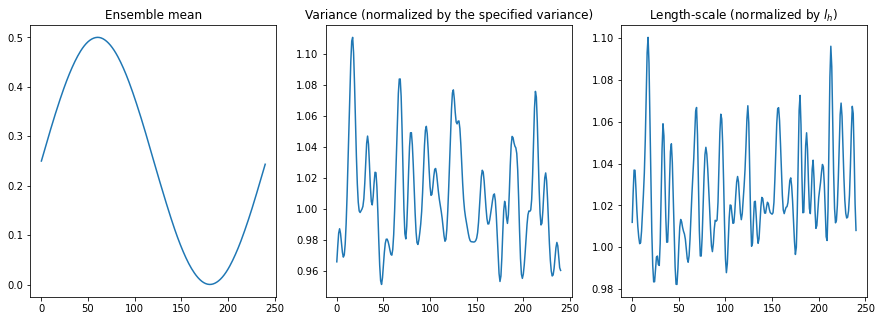

In [37]:
Ne = 1600

ensemble = make_init_ensemble(state0, V0.max(), Ne)

mean = ensemble.mean(axis=0)
std = ensemble.std(axis=0)


print(f"Validation of the mean (=0): {mean.mean()} +/- {mean.std()}" )
print(f"Validation of the standard-deviation (=1): {std.mean()} +/- {std.std()}" )

ens_diagnosis = EnsembleDiagnosis(ensemble, domain)

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(ens_diagnosis.mean)
plt.title('Ensemble mean')

plt.subplot(132)
plt.plot(ens_diagnosis.variance/V0.max())
plt.title('Variance (normalized by the specified variance)')

plt.subplot(133)
plt.plot(ens_diagnosis.length_scale/lh)
plt.title('Length-scale (normalized by $l_h$)')

alert_msg = "Departure between the ensemble estimation of the length-scale and its theoretical value"
assert np.abs(ens_diagnosis.length_scale.mean()/lh-1)<0.1, alert_msg

### Computation of an ensemble of forecast

**Automatic generation of a numerical code solving the Burgers equation**

In [38]:
# Build a numerical code at runtime
exec(FDModelBuilder(burgers_equation, class_name='Burgers').code)
num_burgers = Burgers(shape=(241,), kappa=kappa)

**Generation fo the ensemble of forecast**

The computation of the ensemble of forecast relies on the parallel computation of the time integration of each state of the ensemble

In [39]:
# Build a numerical code at runtime
ensemble_forecast = num_burgers.ensemble_forecast(times, ensemble, saved_times)

In [40]:
# Compute diagnosis from ensemble
ensemble_traj = {}
for time in saved_times:
    diagnosis = EnsembleDiagnosis(ensemble_forecast[time], domain)
    ensemble_traj[time] = [diagnosis.mean, diagnosis.variance, diagnosis.aspect]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:

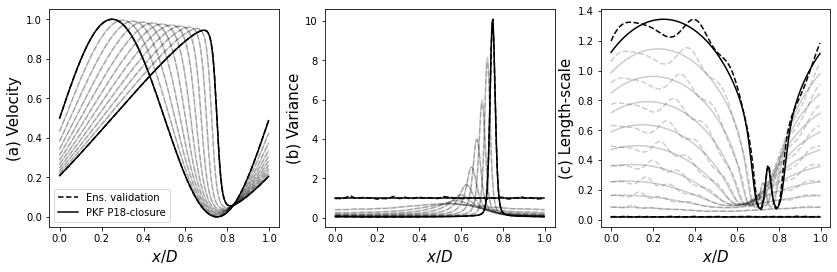

In [41]:
plot_vlatcov_stat(ensemble_traj, name='Ens. validation', style='k--')
plot_vlatcov_stat(pkf_trajectory, name='PKF P18-closure', subplot=True)
#plt.savefig("./figures/sympkf_burgers-simulation.pdf")

We observe that the ensemble estimations of the variance and of the anisotropy (here featured by the length-scale) are in accordance with the dynamics predicted by the PKF closed following P18.

# Conclusion

In this notebook we showed that SymPKF is able to compute the PKF dynamics associated to a given dynamics, by considering the Burgers' equation.

The PKF system for the Burgers' equation being unclosed, we showed how to introduce as closure.

So to perform a numerical simulation, the automatic code generator provided with SymPKF has been used to render a numerical code for the PKF system.